In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel("../data/factor_pricing_data.xlsx", sheet_name="factors (excess returns)")
df.set_index("Date", inplace=True)
df.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0210,0.0029,-0.0043
1980-05-31,0.0526,0.0211,0.0038,0.0034,-0.0031,-0.0112


In [3]:
# 2.1. 
from functools import partial

def performance_stat(s: pd.Series) -> pd.Series:
    """
    Calculate the mean, volatility, sharpe of given series
    
    Parameters:
        s (pd.Series): 
            Excess return of certain asset / portfolio
            Index: all time period (i.e. monthly)
            
    Returns:
        s_stat: Series contains mean, volatility, sharpe of the input series
    """
    s_stat = s.agg(['mean', 'std', partial(np.quantile, q=0.05, axis=0)]).T
    s_stat['mean'] *= 12
    s_stat['std'] *= (12 ** (1/2))
    s_stat['sharpe'] = s_stat['mean'] / s_stat['std']
    return s_stat.rename({"quantile": "var"})

df_stat = df.apply(performance_stat)
df_stat

,MKT,SMB,HML,RMW,CMA,UMD
mean,0.084562,0.011206,0.025324,0.046525,0.032492,0.060925
std,0.157284,0.100525,0.110162,0.083404,0.073379,0.155507
var,-0.075570,-0.042220,-0.042100,-0.027680,-0.027540,-0.068190
sharpe,0.537641,0.111476,0.229880,0.557824,0.442794,0.391780


In [4]:
df_stat_2015 = df.loc['2015':].apply(performance_stat)
df_stat_2015

,MKT,SMB,HML,RMW,CMA,UMD
mean,0.111705,-0.008377,-0.025817,0.048594,0.001794,0.006501
std,0.162705,0.098268,0.135825,0.073131,0.086965,0.144006
var,-0.080850,-0.043480,-0.058610,-0.024000,-0.031950,-0.067430
sharpe,0.686549,-0.085244,-0.190080,0.664483,0.020631,0.045144


2.2. 
All factor has positive premium with all period samples. 
Factors except for SMB (size) and HML (value) has positive premium with since 2015 samples.

Highest correlation: ('CMA', 'HML'); Lowest correlation: ('RMW', 'SMB')


<Axes: >

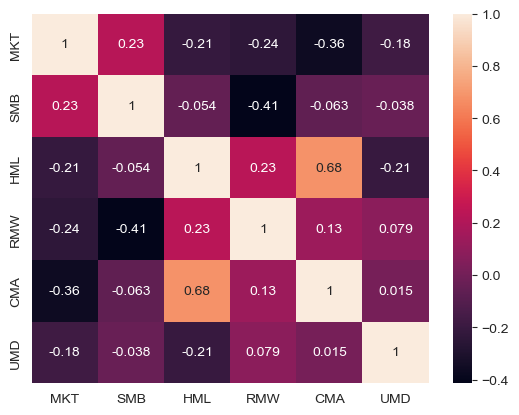

In [5]:
# 2.3. 

def correlation_stat(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate correlation between assets and print highest and lowest correlations pair
    
    Parameters:
        df (pd.DataFrame): 
            Asset returns df.
            Columns: all assets
            Index: all time period (i.e. monthly)
    Returns: 
        pd.DataFrame of correlation matrix
    """
    df_corr = df.corr()
    df_corr_unstack = df_corr.unstack().sort_values()
    df_corr_unstack = df_corr_unstack[df_corr_unstack.index.get_level_values(0) != 
                                      df_corr_unstack.index.get_level_values(1)]
    print(f"Highest correlation: {df_corr_unstack.index[-1]}; Lowest correlation: {df_corr_unstack.index[0]}")
    return df_corr
    
df_corr = correlation_stat(df)

import seaborn as sns
sns.heatmap(df_corr, annot=True)

Yes. HML has high correlation with CMA thus it's redundant. 

In [6]:
# 2.4.

def mv_frontier_tang(df: pd.DataFrame, is_reg: bool = False) -> pd.Series:
    """
    Calculate the tangent portfolio weight on efficient frontier
    
    Parameters:
        df (pd.DataFrame): 
            Excess return df.
            Columns: all assets
            Index: all time period (i.e. monthly)
        is_reg (bool): 
            If True, use regularized covariance matrix.
            
    Returns:
        weight_tang: tangent portfolio weight in ascending order
    """
    df_cov_ann = df.cov()
    if is_reg:
        df_cov_ann += np.diag(np.diag(df_cov_ann))
        df_cov_ann /= 2
    df_cov_mean = pd.Series(np.linalg.inv(df_cov_ann) @ df.mean(), 
                            index=df_cov_ann.columns.to_list(),
                            name='Tangency Weight')
    df_tang = df_cov_mean / df_cov_mean.sum()
    df_tang.sort_values(inplace=True)
    return df_tang

weight_tang = mv_frontier_tang(df)
weight_tang.sort_values()

HML   -0.061776
SMB    0.087446
UMD    0.093818
MKT    0.203875
RMW    0.307353
CMA    0.369283
Name: Tangency Weight, dtype: float64

In [8]:
pd.concat([df_stat.T["mean"], weight_tang], axis=1).sort_values(by="mean")

,mean,Tangency Weight
SMB,0.011206,0.087446
HML,0.025324,-0.061776
CMA,0.032492,0.369283
RMW,0.046525,0.307353
UMD,0.060925,0.093818
MKT,0.084562,0.203875


a) By tangency portfolio weight, CMA is the most important factor and HML is the least important one. 
b) Not sure. Because as seen in the table above, the lowest 3 mean excess returns are SMB, HML, and CMA. While SMB and HML has relatively small weight, CMA has 0.36 weighting and is the most significant factor here.

In [9]:
weight_part_tang = mv_frontier_tang(df[["MKT", "SMB", "UMD", "HML"]])
weight_part_tang.sort_values()

SMB   -0.006204
UMD    0.300861
HML    0.348903
MKT    0.356440
Name: Tangency Weight, dtype: float64

c) Now MKT has the highest tangency weight and SMB has the lowest.

Conclusion:
- HML/UMD becomes much more important when we removed RMW and CMA from the portfolio.
- SMB is not important in both cases. 
- Removing some factors could change the weighting dramatically. 

In [10]:
# 3.1
port = pd.read_excel("../data/factor_pricing_data.xlsx", sheet_name="portfolios (excess returns)")
port.set_index("Date", inplace=True)
port.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0076,0.0285,0.0084,0.1009,-0.0143,0.1002,0.0362,0.0323,0.0048,0.0059,...,0.0158,0.0875,0.0465,-0.0126,0.0430,-0.0283,0.0258,0.0768,0.0308,0.0669
1980-02-29,0.0105,-0.0608,-0.0966,-0.0322,-0.0569,-0.0323,-0.0521,-0.0800,-0.0555,-0.0167,...,-0.0079,-0.0541,-0.0346,-0.0639,-0.0652,-0.0854,-0.0959,-0.0347,-0.0282,-0.0274
1980-03-31,-0.2224,-0.1119,-0.0167,-0.1469,-0.0193,-0.1271,-0.0826,-0.1237,-0.0566,-0.0668,...,-0.0819,-0.1509,-0.1098,-0.0906,-0.1449,-0.0560,-0.0880,-0.2451,-0.1254,-0.1726
1980-04-30,0.0449,0.0766,0.0232,0.0321,0.0830,-0.0529,0.0783,0.0153,0.0304,0.0115,...,0.0420,-0.0103,-0.0312,0.0353,0.0542,0.0728,0.0530,0.0977,0.0447,0.0769
1980-05-31,0.0632,0.0793,0.0457,0.0863,0.0815,0.0509,0.0324,0.0886,0.0560,0.0098,...,0.0564,0.1063,0.1142,0.0877,0.1134,0.0578,0.0557,0.0915,0.0844,0.0685


In [11]:
from sklearn.linear_model import LinearRegression

def linear_regression_stat(s: pd.Series, factor_list: list[str]) -> pd.Series:
    """
    Run time-series linear regression of certain asset returns 
    against different factors and report annualized alpha / beta / R^2
    
    Parameters:
        s (pd.Series): 
            Return series of certain asset
        factor_list (list[str]):
            List of factors to run regression. 
        
    Returns:
        pd.Series of all annualized statistics of given asset
    """
    factor = df.loc[s.index, factor_list]
    reg = LinearRegression().fit(factor, s)
    
    return pd.Series({
        "alpha": reg.intercept_ * 12,
        "r_square": reg.score(factor, s),
        "beta": reg.coef_
    })

port_stat = port.apply(partial(linear_regression_stat, 
                               factor_list=["MKT", "HML", "RMW", "UMD"]), axis=0).T
port_stat

,alpha,r_square,beta
Agric,0.009491,0.341333,"[0.8378377626632936, 0.17869949509319694, -0.0..."
Food,0.011434,0.471088,"[0.6809033215898298, 0.1698407008811335, 0.507..."
Soda,0.019555,0.307178,"[0.7846882641472345, 0.20610588069107993, 0.49..."
Beer,0.024178,0.426698,"[0.7233302143813405, 0.025182692318808153, 0.6..."
Smoke,0.035317,0.272555,"[0.737220230517355, 0.2493440067788692, 0.6574..."
Toys,-0.032189,0.510315,"[1.1168240816190282, -0.03533577306999296, 0.2..."
Fun,0.031788,0.617319,"[1.2488683525212823, 0.00017733563035710054, -..."
Books,-0.030329,0.689702,"[1.1135656021566633, 0.26547371306713075, 0.17..."
Hshld,-0.00551,0.560258,"[0.7528024656409584, 0.0008890194963793174, 0...."
Clths,-0.011724,0.631763,"[1.1186135117375888, 0.04947501423351461, 0.56..."


In [12]:
mae = port_stat["alpha"].abs().mean()
mae

0.022995449182633243

If pricing model works, the alpha should be low (ideally 0), because ARQ model implies MKT / HML / RMW / UMD could fully explain the excess returns. 
By our MAE stat = 2.3% per year, the pricing model is not true, because we could not ignore the average +/-2.3% alpha is not ignorable, given the mean excess returns of factors are just single digit percentage.

In [13]:
# 3.2.

port_stat_capm = port.apply(partial(linear_regression_stat, 
                                    factor_list=["MKT"]), axis=0).T
port_stat_fm3 = port.apply(partial(linear_regression_stat, 
                                   factor_list=["MKT", "SMB", "HML"]), axis=0).T
port_stat_fm5 = port.apply(partial(linear_regression_stat, 
                                   factor_list=["MKT", "SMB", "HML", "RMW", "CMA"]), axis=0).T
pd.Series({
    "AQR": mae,
    "CAPM": port_stat_capm["alpha"].abs().mean(),
    "FF3": port_stat_fm3["alpha"].abs().mean(),
    "FF5": port_stat_fm5["alpha"].abs().mean(),
}, name="MAE").sort_values()

CAPM    0.020608
AQR     0.022995
FF3     0.024200
FF5     0.031272
Name: MAE, dtype: float64

By MAE, CAPM fits the best, although 2% excess return is still not fitting perfectly.

3.3.
We notice MAE of Fama-French 5 factor (FF5) model is much higher than Fama-French 3 factor (FF3) model, therefore RMW and CMA seems to be unimportant for pricing. 
On the other hand, AQR model has slightly lower MAE than FF3 model, which indicates the extra UMD (momentum) factor improve the pricing model and should be included.

In [14]:
# 3.4.
pd.Series({
    "AQR": port_stat["r_square"].mean(),
    "CAPM": port_stat_capm["r_square"].mean(),
    "FF3": port_stat_fm3["r_square"].mean(),
    "FF5": port_stat_fm5["r_square"].mean(),
}, name="Average R2").sort_values()

CAPM    0.528087
FF3     0.572516
AQR     0.577081
FF5     0.597519
Name: Average R2, dtype: float64

Maximum average R2 is for FF5 model at ~0.6, which is still relatively low, i.e. not great for linear factor decomposition. But given the conditions, it's useful in a way.

In [25]:
# 3.5. 
from sklearn.metrics import mean_absolute_error

def cross_sectional_regression(s: pd.Series, factor_list: list[str]) -> pd.Series:
    """
    Run cross-sectional linear regression for different models
    
    Parameters:
        s (pd.Series): 
            Beta series of certain asset
        factor_list (list[str]):
            List of factors to run regression. 
        
    Returns:
        pd.Series of annualized statistics of given asset
    """
    factor = pd.DataFrame(s.to_list(), index=s.index, columns=factor_list)
    avg_ret = port.mean()
    reg = LinearRegression().fit(factor, avg_ret)
    pred_ret = reg.predict(factor)
    
    return pd.Series({
        # "alpha": reg.intercept_ * 12,
        "mae": (avg_ret - pred_ret).abs().mean() * 12,
        # "mae": mean_absolute_error(avg_ret, pred_ret) * 12,
        # "r_square": reg.score(factor, s),
        "lambda": dict(zip(factor_list, reg.coef_ * 12))
    })

In [26]:
cross_stat = pd.DataFrame([
    cross_sectional_regression(port_stat["beta"], ["MKT", "HML", "RMW", "UMD"]).rename("AQR"),
    cross_sectional_regression(port_stat_fm3["beta"], ["MKT", "HML", "SMB"]).rename("FF3"),
    cross_sectional_regression(port_stat_fm5["beta"], ["MKT", "SMB", "HML", "RMW", "CMA"]).rename("FF5"),
])
cross_stat

,mae,lambda
AQR,0.013738,"{'MKT': 0.01993286610667801, 'HML': -0.0332271..."
FF3,0.012258,"{'MKT': 0.039742033909905786, 'HML': -0.043387..."
FF5,0.011547,"{'MKT': 0.04642533841245833, 'SMB': -0.0466876..."


In [19]:
premia_comp = pd.concat([
    pd.DataFrame(cross_stat["lambda"].to_list(), index=cross_stat.index).T,
    df.mean().rename("Time Series") * 12
], axis=1)
premia_comp

,AQR,FF3,FF5,Time Series
MKT,0.019933,0.039742,0.046425,0.084562
HML,-0.033227,-0.043388,-0.028500,0.025324
RMW,0.023276,-0.020863,0.025863,0.046525
UMD,0.002402,NaN,NaN,0.060925
SMB,NaN,NaN,-0.046688,0.011206
CMA,NaN,NaN,-0.023940,0.032492


<Axes: title={'center': 'Premia Comparison'}>

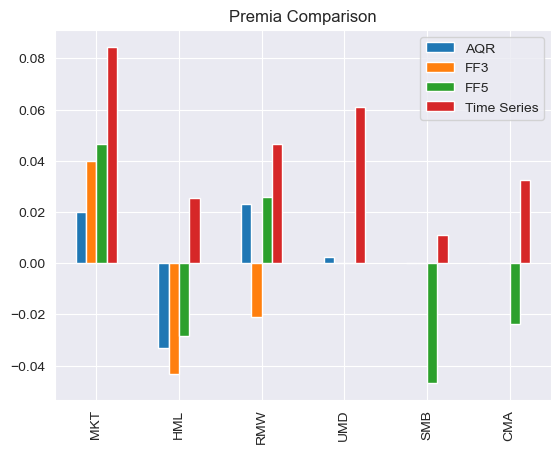

In [20]:
premia_comp.plot.bar(title="Premia Comparison")

a) Based on the plot above, time-series premia differs quite a lot from the cross-sectional estimations in all 3 models. The most consistent part is the MKT factor always has a positive premia. 
b) Cross-sectional MAE are all lower than the time series regressions. And the ranking inverses. Cross-sectional MAE of FF5 < FF3 < AQR, and therefore makes FF5 the best pricing model comparatively.

In [66]:
# 4.1. 
pit_premia = df.expanding(60).mean().dropna()
pit_premia

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1984-12-31,0.003773,0.003482,0.007727,0.003627,0.005032,0.008633
1985-01-31,0.005021,0.004000,0.006723,0.003421,0.004390,0.007374
1985-02-28,0.005137,0.004103,0.006598,0.003574,0.004490,0.007558
1985-03-31,0.004922,0.003817,0.007140,0.003713,0.004876,0.007689
1985-04-30,0.004695,0.003742,0.007609,0.003897,0.004911,0.008044
...,...,...,...,...,...,...
2023-03-31,0.006896,0.000917,0.002202,0.003864,0.002832,0.005221
2023-04-30,0.006895,0.000866,0.002197,0.003903,0.002881,0.005242
2023-05-31,0.006888,0.000857,0.002044,0.003861,0.002737,0.005220


In [78]:
def point_in_time_reg(s: pd.Series, t: np.datetime64) -> float:
    """
    Run point in time linear regression of certain asset returns 
    and calculate the expected return with point-in-time factor premia
    
    Parameters:
        s (pd.Series): 
            Return series of certain asset
        t (np.datetime64):
            Cut-off time for point in time regression
        
    Returns:
        float: expected return of certain asset
    """
    factor_list = ["MKT", "HML", "RMW", "UMD"]
    reg = LinearRegression().fit(
        df.loc[df.index < t, factor_list], 
        s.loc[s.index < t]
    )
    return (reg.coef_ * pit_premia.loc[t, factor_list]).sum()

pit_ret = {}
for t in pit_premia.index:
    pit_ret[t] = port.apply(point_in_time_reg, t=t)

In [87]:
pit_ret_df = pd.DataFrame(pit_ret).T.shift(1).dropna()
pit_ret_df

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1985-01-31,0.005574,0.003549,0.002372,0.008528,0.007286,-0.005621,-0.001132,0.002131,-0.001198,-0.003804,...,0.000818,-0.000923,-0.001075,-0.001493,-0.001438,0.004178,0.001734,0.001998,0.006392,-0.002478
1985-02-28,0.006694,0.004453,0.002962,0.008830,0.008150,-0.003658,-0.000098,0.003735,0.000130,-0.002304,...,0.002173,0.000962,0.000832,-0.000057,0.000179,0.005688,0.003095,0.003639,0.007542,-0.000682
1985-03-31,0.007790,0.005682,0.004887,0.008631,0.009478,-0.002941,-0.002101,0.003635,0.000557,-0.002564,...,0.002723,0.001723,0.000313,-0.000436,0.000231,0.005742,0.002705,0.003687,0.007678,-0.001102
1985-04-30,0.007871,0.005885,0.005224,0.008705,0.010020,-0.003854,-0.002492,0.003298,0.000217,-0.003062,...,0.002438,0.001246,-0.000335,-0.000825,-0.000085,0.005643,0.002668,0.003216,0.007577,-0.001685
1985-05-31,0.007845,0.006595,0.007131,0.009265,0.010116,-0.004315,-0.002009,0.003841,-0.000549,-0.003153,...,0.002084,0.000463,-0.000697,-0.001274,-0.000076,0.005456,0.002217,0.002434,0.007328,-0.001708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,0.006468,0.007266,0.007325,0.007798,0.007932,0.007543,0.006945,0.008536,0.006993,0.008752,...,0.007264,0.008800,0.008054,0.007429,0.008209,0.009252,0.008626,0.008607,0.007485,0.007792
2023-04-30,0.006471,0.007277,0.007344,0.007832,0.007951,0.007616,0.007003,0.008548,0.007043,0.008833,...,0.007305,0.008817,0.008071,0.007519,0.008255,0.009179,0.008592,0.008574,0.007460,0.007818
2023-05-31,0.006485,0.007289,0.007346,0.007853,0.007981,0.007643,0.006996,0.008572,0.007054,0.008850,...,0.007325,0.008840,0.008084,0.007537,0.008271,0.009210,0.008612,0.008599,0.007472,0.007818
2023-06-30,0.006449,0.007240,0.007296,0.007823,0.007918,0.007623,0.006997,0.008520,0.007038,0.008820,...,0.007283,0.008777,0.008050,0.007538,0.008245,0.009095,0.008531,0.008514,0.007433,0.007809


In [88]:
benchmark_df = port.expanding(60).mean().shift(1).dropna()
benchmark_df

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-31,0.005825,0.008685,0.008093,0.008317,0.011048,0.006803,0.002703,0.011810,0.004662,0.007275,...,0.006040,0.007298,0.008363,0.009792,0.006968,0.006190,0.004945,0.006688,0.007435,0.003307
1985-02-28,0.006052,0.008728,0.007490,0.008828,0.011131,0.008370,0.005223,0.013513,0.005710,0.009066,...,0.007105,0.008687,0.010689,0.011613,0.008557,0.007528,0.006397,0.008359,0.008546,0.005480
1985-03-31,0.006806,0.009419,0.008432,0.008805,0.012440,0.007942,0.005976,0.013432,0.005634,0.009111,...,0.006903,0.008874,0.010452,0.011713,0.008981,0.007400,0.006968,0.008132,0.008602,0.005842
1985-04-30,0.006746,0.010063,0.010062,0.009289,0.012640,0.007365,0.006246,0.013863,0.004968,0.008973,...,0.006619,0.008137,0.010063,0.011313,0.008951,0.007325,0.006630,0.007444,0.008403,0.005686
1985-05-31,0.007391,0.009438,0.009511,0.009294,0.011059,0.006377,0.006347,0.013583,0.004611,0.008731,...,0.006030,0.007370,0.009709,0.011078,0.008794,0.007602,0.006958,0.007138,0.008466,0.005389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,0.007742,0.008370,0.009035,0.009863,0.011130,0.005238,0.009637,0.006133,0.006745,0.008270,...,0.007724,0.007370,0.007033,0.009084,0.008547,0.007513,0.008050,0.003959,0.009251,0.004045
2023-04-30,0.007669,0.008413,0.009110,0.009917,0.011103,0.005197,0.009670,0.006041,0.006824,0.008329,...,0.007687,0.007333,0.007024,0.009131,0.008588,0.007272,0.007937,0.003787,0.009081,0.004077
2023-05-31,0.007648,0.008447,0.009151,0.009972,0.011154,0.005121,0.009660,0.006056,0.006888,0.008349,...,0.007627,0.007267,0.007012,0.009141,0.008662,0.007285,0.007986,0.003764,0.009063,0.004165


In [97]:
oos_r2 = 1 - ((pit_ret_df - port.loc[pit_ret_df.index]).pow(2).mean() / 
              (benchmark_df - port.loc[pit_ret_df.index]).pow(2).mean())
oos_r2.rename("OOS R2").sort_values()

Softw   -0.031879
MedEq   -0.010478
LabEq   -0.007903
Chips   -0.007655
ElcEq   -0.005708
Other   -0.005077
Hardw   -0.005066
Drugs   -0.004858
BusSv   -0.004321
Insur   -0.004187
Paper   -0.004123
Rtail   -0.003839
Hshld   -0.003285
PerSv   -0.003005
Whlsl   -0.002950
Meals   -0.002804
Toys    -0.002470
Fun     -0.002444
Rubbr   -0.001955
Banks   -0.001850
Trans   -0.001390
Food    -0.001301
Util    -0.001083
BldMt   -0.001064
Clths   -0.001042
Books   -0.000906
Boxes   -0.000735
Txtls   -0.000119
Chems    0.000249
Soda     0.000300
Autos    0.000630
Fin      0.000661
Beer     0.000673
Smoke    0.000736
Hlth     0.000853
Aero     0.000949
Oil      0.001752
Steel    0.002301
Mach     0.002340
RlEst    0.002641
Guns     0.002725
Gold     0.002899
Agric    0.003129
Cnstr    0.004002
FabPr    0.004382
Telcm    0.004475
Coal     0.005418
Mines    0.005483
Ships    0.008723
Name: OOS R2, dtype: float64

In [98]:
oos_r2.mean()

-0.0013914272730581856

4.1. Not doing a good job. TODO???? Is this make sense.